# Problem Setting: Image Classification with hand-written DIGITS.

This notebook demonstrates the Deep Reconstruction-Classification Networks(DRCNetworks or DRCN) can learn images and discriminates its. Image dataset for this demo is the MNIST. The code of this notebook is written on the premise that the MNIST images are divided and arranged in directories for each label beforehand.

Generally, the ratio between the learning data and the test data is set such that the learning data becomes large, such as `7:3`. However, in this notebook, we reverse this ratio and let the model perform training and inference on a data set adjusted by a ratio of `3:7`, in order to create so-called **dataset bias**.

**Note** that the difficulty of classification and identification will not increase with this level of bias. However, this is just a demo, so this level of difficulty should be okay. In the real world, which is not limited to laboratories, there is a large amount of data that is heavily biased, so I encourage everyone to try it out with such an ugly dataset.

# Problem Re-setting: Dataset bias.

Deep Reconstruction-Classification Network(DRCNetworks or DRCN) is a convolutional network that jointly learns two tasks: 
    
1. supervised source label prediction.
2. unsupervised target data reconstruction. 

Ideally, a discriminative representation should model both the label and the structure of the data. Based on that intuition, Ghifary, M., et al.(2016) hypothesize that a domain-adaptive representation should satisfy two criteria:
    
1. classify well the source domain labeled data.
2. reconstruct well the target domain unlabeled data, which can be viewed as an approximate of the ideal discriminative representation.

The encoding parameters of the DRCNetworks are shared across both tasks, while the decoding parameters are sepa-rated. The aim is that the learned label prediction function can perform well onclassifying images in the target domain thus the data reconstruction can beviewed as an auxiliary task to support the adaptation of the label prediction.

## Problem Solution: Domain Adaptation by DRCNetworks.

Firstly, import Python modules for building DRCNetworks.

In [1]:
from accelbrainbase.computableloss._mxnet.drcn_loss import DRCNLoss
from accelbrainbase.computableloss._mxnet.l2_norm_loss import L2NormLoss
from accelbrainbase.extractabledata._mxnet.image_extractor import ImageExtractor
from accelbrainbase.iteratabledata._mxnet.drcn_iterator import DRCNIterator
from accelbrainbase.noiseabledata._mxnet.gauss_noise import GaussNoise
from accelbrainbase.observabledata._mxnet.convolutionalneuralnetworks.drc_networks import DRCNetworks
from accelbrainbase.observabledata._mxnet.convolutional_neural_networks import ConvolutionalNeuralNetworks
from accelbrainbase.observabledata._mxnet.convolutionalneuralnetworks.convolutionalautoencoder.convolutional_ladder_networks import ConvolutionalLadderNetworks
from accelbrainbase.observabledata._mxnet.neural_networks import NeuralNetworks

In [3]:
import mxnet as mx
import mxnet.ndarray as nd
import numpy as np
import pandas as pd
from mxnet.gluon.nn import Conv2D
from mxnet.gluon.nn import Conv2DTranspose
from mxnet.gluon.nn import BatchNorm

If you want to observe the learning log, set `getLogger`.

In [2]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("accelbrainbase")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

Build and initialize `ImageExtractor`, specifying parameters such as image size.

In [4]:
image_extractor = ImageExtractor(
    # `int` of image width.
    width=28,
    # `int` of image height.
    height=28,
    # `int` of image channel.
    channel=1,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu()
)

Build and initialize `DRCNIterator`, delegating `image_extractor` and specifying parameters such as file path to image files.

In [5]:
drcn_iterator = DRCNIterator(
    # is-a `ImageExtractor`.
    image_extractor=image_extractor,
    # `list` of paths to image files in learning.
    dir_list=[
        "../../../../Downloads/digit-recognizer/train/0/", 
        "../../../../Downloads/digit-recognizer/train/1/", 
        "../../../../Downloads/digit-recognizer/train/2/", 
        "../../../../Downloads/digit-recognizer/train/3/", 
        "../../../../Downloads/digit-recognizer/train/4/", 
        "../../../../Downloads/digit-recognizer/train/5/", 
        "../../../../Downloads/digit-recognizer/train/6/", 
        "../../../../Downloads/digit-recognizer/train/7/", 
        "../../../../Downloads/digit-recognizer/train/8/", 
        "../../../../Downloads/digit-recognizer/train/9/", 
    ],
    # `list` of paths to image files in test.
    test_dir_list=[
        "../../../../Downloads/digit-recognizer/test/0/", 
        "../../../../Downloads/digit-recognizer/test/1/", 
        "../../../../Downloads/digit-recognizer/test/2/", 
        "../../../../Downloads/digit-recognizer/test/3/", 
        "../../../../Downloads/digit-recognizer/test/4/", 
        "../../../../Downloads/digit-recognizer/test/5/", 
        "../../../../Downloads/digit-recognizer/test/6/", 
        "../../../../Downloads/digit-recognizer/test/7/", 
        "../../../../Downloads/digit-recognizer/test/8/", 
        "../../../../Downloads/digit-recognizer/test/9/", 
    ],
    # `list` of paths to image files in domain adaptation.
    target_domain_dir_list=[
        "../../../../Downloads/digit-recognizer/domain-adaptation/", 
    ],
    # `int` of epochs.
    epochs=3000,
    # `int` of batch size.
    batch_size=40,
    # How to normalize pixel values of images.
    # - `z_score`: Z-Score normalization.
    # - `min_max`: Min-max normalization.
    # - others : This class will not normalize the data.
    norm_mode="z_score",
    # `float` of scaling factor for data.
    scale=1.0,
    # is-a `NoiseableData`.
    noiseable_data=GaussNoise(sigma=1e-03, mu=0.0),
)

Build and initialize loss function.

In [6]:
computable_loss = L2NormLoss()
drcn_loss = DRCNLoss(
    # Global scalar weight for total loss.
    weight=1.0,
    # Global scalar weight for classification loss. If `None`, this value will be equivalent to `weight`.
    classification_weight=None,
    # Global scalar weight for reconstruction loss. If `None`, this value will be equivalent to `weight`.
    reconstruction_weight=1/(1*28*28), 
)

Build and initialize `NeuralNetworks` as an output layer.

In [7]:
output_nn = NeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=drcn_loss,
    # `list` of int` of the number of units in hidden/output layers.
    units_list=[100, 10],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    activation_list=["relu", "identity"],
    # `list` of `float` of dropout rate.
    dropout_rate_list=[0.5, 0.0],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), None],
    # `bool` for using bias or not in output layer(last hidden layer).
    output_no_bias_flag=True,
    # `bool` for using bias or not in all layer.
    all_no_bias_flag=True,
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalNeuralNetworks` as an encoder.

In [8]:
encoder = ConvolutionalNeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `list` of int` of the number of units in hidden layers.
    hidden_units_list=[
        # `mxnet.gluon.nn.Conv2D`.
        Conv2D(
            channels=16,
            kernel_size=6,
            strides=(2, 2),
            padding=(1, 1),
        ), 
        Conv2D(
            channels=32,
            kernel_size=3,
            strides=(1, 1),
            padding=(1, 1),
        ),
    ],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    hidden_activation_list=["relu", "relu"],
    # `list` of `float` of dropout rate.
    hidden_dropout_rate_list=[0.0, 0.0],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), BatchNorm()],
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalNeuralNetworks` as a decoder.

In [9]:
decoder = ConvolutionalNeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `list` of int` of the number of units in hidden layers.
    hidden_units_list=[
        # `mxnet.gluon.nn.Conv2DTranspose`.
        Conv2DTranspose(
            channels=16,
            kernel_size=3,
            strides=(1, 1),
            padding=(1, 1),
        ), 
        Conv2DTranspose(
            channels=1,
            kernel_size=6,
            strides=(2, 2),
            padding=(1, 1),
        ),
    ],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    hidden_activation_list=["relu", "identity"],
    # `list` of `float` of dropout rate.
    hidden_dropout_rate_list=[0.0, 0.0],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), None],
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalNeuralNetworks` as a `ConvolutionalAutoEncoder`, delegating `encoder` and `decoder`.

In [10]:
CAE = ConvolutionalLadderNetworks(
    # is-a `ConvolutionalNeuralNetworks`.
    encoder=encoder,
    # is-a `ConvolutionalNeuralNetworks`.
    decoder=decoder,
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `bool` of flag to tied weights or not.
    tied_weights_flag=True,
    # `str` of name of optimizer.
    optimizer_name="adam",
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `DRCNetworks`, delegating `CAE`.

In [11]:
DRCN = DRCNetworks(
    # is-a `ConvolutionalAutoEncoder`.
    convolutional_auto_encoder=CAE,
    # is-a `DRCNLoss`.
    drcn_loss=drcn_loss,
    # is-a `mxnet.initializer` for parameters of model. If `None`, it is drawing from the Xavier distribution.
    initializer=None,
    # `float` of learning rate.
    learning_rate=1e-03,
    # `float` of attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=1.0,
    # `int` of attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # is-a `NeuralNetworks` or `mxnet.gluon.block.hybridblock.HybridBlock`.
    output_nn=output_nn,
    # `str` of name of optimizer.
    optimizer_name="adam",
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Start learning.

In [12]:
DRCN.learn(drcn_iterator)

Epochs: 100 Train total loss: 0.38701215 Test total loss: 0.3521584
Train classification loss: 0.38608733 Test classification loss: 0.35122555
Train reconstruction loss: 0.00092481135 Test reconstruction loss: 0.0009328293
----------------------------------------------------------------------------------------------------
Train accuracy: 0.85 Test accuracy: 0.925
Train infenreced label(inferenced):
[8. 9. 4. 8. 6. 1. 3. 4. 5. 3. 2. 8. 4. 0. 0. 6. 7. 0. 7. 4. 3. 3. 5. 0.
 3. 2. 5. 8. 3. 0. 1. 9. 3. 9. 7. 5. 9. 0. 8. 0.]
Train infenreced label(answer):
[8. 9. 4. 8. 6. 1. 3. 4. 8. 5. 2. 8. 4. 0. 0. 6. 7. 0. 9. 4. 3. 3. 6. 0.
 3. 2. 5. 8. 3. 3. 1. 9. 3. 4. 7. 5. 9. 0. 8. 0.]
Test infenreced label(inferenced):
[2. 9. 8. 4. 6. 7. 2. 0. 7. 7. 7. 4. 5. 1. 0. 4. 1. 9. 8. 7. 0. 5. 5. 1.
 2. 1. 9. 8. 8. 3. 5. 0. 1. 5. 1. 1. 2. 3. 5. 9.]
Test infenreced label(answer):
[2. 3. 8. 4. 6. 7. 2. 0. 7. 7. 7. 4. 5. 1. 0. 0. 1. 9. 8. 7. 0. 5. 5. 2.
 2. 1. 9. 8. 8. 3. 5. 0. 1. 5. 1. 1. 2. 3. 5. 9.]
--------

Visualize losses and accuracies.

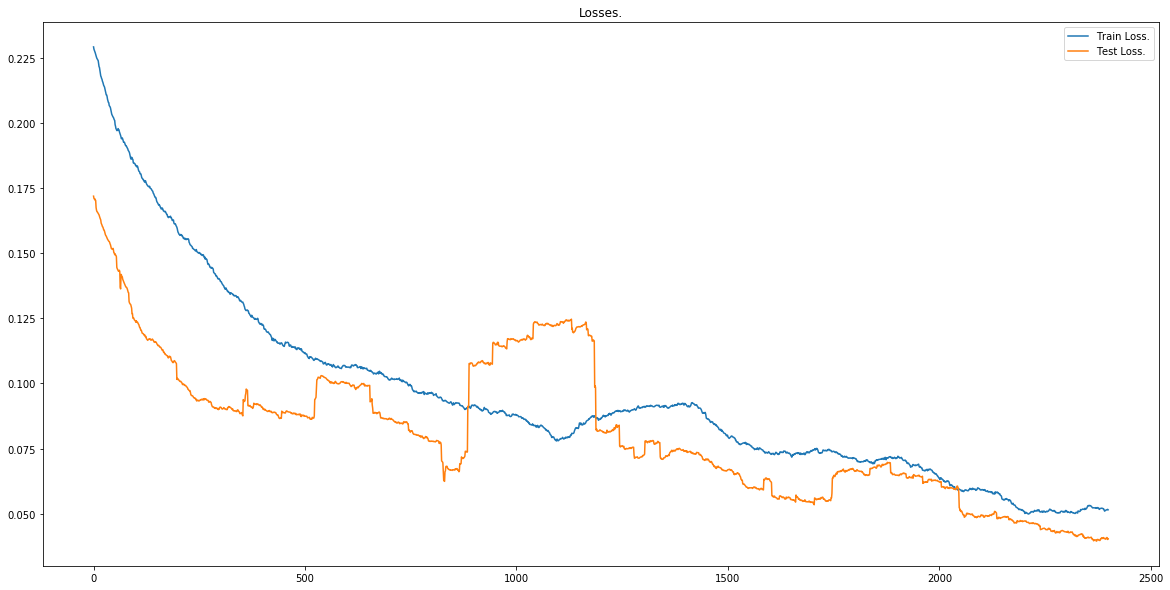

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def moving_avg(arr, window=300):
    return np.convolve(arr, np.ones(window) / window, mode='same')[window:-window]

plt.figure(figsize=(20, 10))
plt.plot(moving_avg(DRCN.loss_arr[:, 0]), label="Train Loss.")
plt.plot(moving_avg(DRCN.loss_arr[:, 1]), label="Test Loss.")
plt.legend()
plt.title("Losses.")
plt.show()

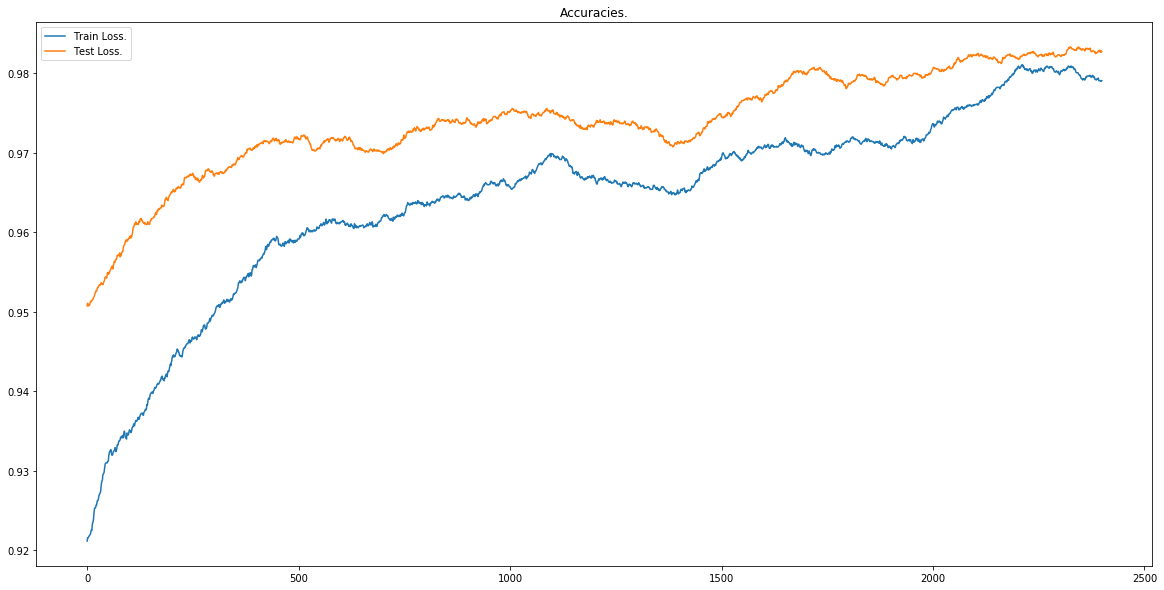

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(moving_avg(DRCN.acc_arr[:, 0]), label="Train Loss.")
plt.plot(moving_avg(DRCN.acc_arr[:, 1]), label="Test Loss.")
plt.legend()
plt.title("Accuracies.")
plt.show()

As a verification, let's calculate the accuracy of the test data.

In [15]:
test_arr = None
test_label_arr = None
total_acc = 0.0
i = 0
for _, _, _test_arr, _label_test_arr, target_arr in drcn_iterator.generate_learned_samples():
    test_arr = _test_arr
    test_label_arr = _label_test_arr
    decoded_arr, prob_arr = DRCN.inference(test_arr)
    acc, _, _ = DRCN.compute_acc(prob_arr, test_label_arr)
    total_acc += acc
    i += 1
    if i >= 50:
        break
avg_acc = total_acc / i
avg_acc

0.9810000038146973

## For ML Ops.

This model inherits [HybridBlock](https://gluon.mxnet.io/chapter07_distributed-learning/hybridize.html) from [mxnet.gluon](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/index.html). Functions for common ML Ops such as saving and loading parameters are provided by [HybridBlock](https://mxnet.apache.org/api/python/docs/api/gluon/hybrid_block.html).

# References

- Ghifary, M., Kleijn, W. B., Zhang, M., Balduzzi, D., & Li, W. (2016, October). Deep reconstruction-classification networks for unsupervised domain adaptation. In European Conference on Computer Vision (pp. 597-613). Springer, Cham.